In [1]:
import gzip
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import os
import shutil
import json
import io

# Inspect full image archive without extracting all files

In [2]:
%%time
_pwd = b'2019Deepfashion2**'
zipf = zipfile.ZipFile('validation.zip')

CPU times: user 469 ms, sys: 18.1 ms, total: 487 ms
Wall time: 487 ms


In [3]:
filenames = zipf.namelist()
df = pd.DataFrame([x.split('/') for x in filenames[:]], columns=['root_path', 'folder', 'filename'])
df['path'] = filenames

In [4]:
df = df.dropna()
df = df[df.filename != '']
df = df.reset_index()
print(len(df))
df.sample(n=5)

64306


,index,root_path,folder,filename,path
22173,22175,validation,annos,007187.json,validation/annos/007187.json
26721,26723,validation,annos,020865.json,validation/annos/020865.json
42040,42043,validation,image,030570.jpg,validation/image/030570.jpg
60671,60674,validation,image,014111.jpg,validation/image/014111.jpg
6326,6328,validation,annos,011360.json,validation/annos/011360.json


In [5]:
osize = 0 
for item in zipf.infolist():
    osize += item.file_size
print('uncompressed size =',round(osize/1000000000,2),'GB')

uncompressed size = 1.95 GB


# Basic EDA


In [6]:
samples = df[df['folder']=='image']['path'].sample(10)

In [7]:
samples

51095    validation/image/026321.jpg
47736    validation/image/016672.jpg
56618    validation/image/018476.jpg
59939    validation/image/029092.jpg
52146    validation/image/002110.jpg
55479    validation/image/013526.jpg
36004    validation/image/030793.jpg
61789    validation/image/020550.jpg
47076    validation/image/029142.jpg
61367    validation/image/009361.jpg
Name: path, dtype: object

In [8]:
samples = df[df['folder']=='image']['path'].sample(10)
annos = []
bboxes = []
images = []
for file in samples[:1]: 
    anno = zipf.read(file.replace('.jpg','.json').replace('/image/','/annos/'), pwd=_pwd)
    anno = json.loads(str(anno)[2:-1])
    annos.append(anno)
    
    bbox = anno['item1']['bounding_box']
    bboxes.append(bbox)
    
    img = Image.open(io.BytesIO(zipf.read(file, pwd=_pwd)))
    images.append(img)

In [9]:
annos = []
bboxes = []
images = []
for file in samples[:1]: 
    anno = zipf.read(file.replace('.jpg','.json').replace('/image/','/annos/'), pwd=_pwd)
    anno = json.loads(str(anno)[2:-1])
    annos.append(anno)
    
    bbox = anno['item1']['bounding_box']
    bboxes.append(bbox)
    
    img = Image.open(io.BytesIO(zipf.read(file, pwd=_pwd)))
    images.append(img)

In [10]:
#anno['item1'].keys()
#dict_keys(['segmentation', 'scale', 'viewpoint', 'zoom_in', 'landmarks', 'style', 'bounding_box', 'category_id', 'occlusion', 'category_name'])

In [11]:
if False:
    segs = anno['item1']['segmentation'][0]
    segs_arr = np.array([str(x).split('.') for x in segs])

    marks = []
    for idx in range(0,len(anno['item1']['landmarks']),3):
        x = anno['item1']['landmarks'][idx]
        y = anno['item1']['landmarks'][idx+1]
        if not(x==0 & y==0):
            marks.append([x,y])
    marks_arr = np.array(marks)
    #marks_arr = marks_arr[marks_arr[:, 0].argsort()]

### Inspect a few sample images and corresponding bounding boxes

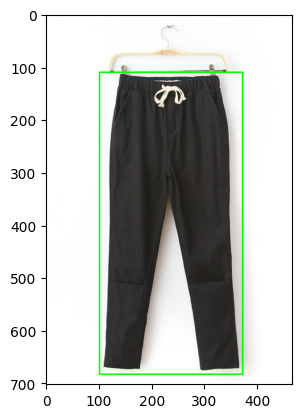

In [14]:
for img, bbox in zip(images, bboxes):
    (x1, y1, x2, y2) = bbox
    img_bbox = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(img_bbox)
    plt.show()

# Examine classes

In [15]:
%%time

ids = []
sources = []
scales = []
viewpoints = []
zooms = []
occlusions = []
landmarks = []
bboxes = []
styles = []
category_ids = []
category_names = []
annos = df[df['folder']=='annos']
print('# rows', len(annos))
for idx, row in tqdm(annos.iterrows()): 
    file = row.path
    anno = zipf.read(file, pwd=_pwd)
    anno = json.loads(str(anno)[2:-1])
    
    for key in anno.keys():
        if 'item' in key:
            ids.append(row.filename.split('.')[0])
            sources.append(anno['source'])
            #anno.keys() => dict_keys(['segmentation', 'scale', 'viewpoint', 'zoom_in', 'landmarks', 'style', 'bounding_box', 'category_id', 'occlusion', 'category_name'])
            scales.append(anno[key]['scale'])
            viewpoints.append(anno[key]['viewpoint'])
            zooms.append(anno[key]['zoom_in'])
            occlusions.append(anno[key]['occlusion'])
            landmarks.append(anno[key]['landmarks'])
            bboxes.append(anno[key]['bounding_box'])
            styles.append(anno[key]['style'])
            category_ids.append(anno[key]['category_id'])
            category_names.append(anno[key]['category_name'])    

# rows 32153


0it [00:00, ?it/s]

CPU times: user 1min 57s, sys: 1.29 s, total: 1min 58s
Wall time: 1min 59s


In [16]:
df_meta_all = pd.DataFrame(data=zip(ids, sources, scales, viewpoints, zooms, occlusions, landmarks, bboxes, styles, category_ids, category_names), columns=['id', 'source', 'scale', 'viewpoint', 'zoom', 'occlusion', 'landmarks', 'bbox', 'style', 'category_id', 'category_name'])
print(len(df_meta_all))
df_meta_all[:5]

52490


,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id,category_name
0,003690,user,1,3,1,1,"[245, 94, 1, 266, 91, 1, 0, 0, 0, 0, 0, 0, 0, ...","[170, 88, 336, 246]",0,2,long sleeve top
1,003690,user,1,3,1,1,"[305, 229, 1, 261, 237, 2, 224, 244, 2, 327, 3...","[210, 219, 331, 419]",1,9,skirt
2,003690,user,2,3,1,3,"[302, 228, 1, 260, 234, 1, 222, 237, 1, 323, 3...","[209, 226, 325, 590]",0,8,trousers
3,003648,user,1,2,3,2,"[191, 516, 1, 205, 567, 1, 0, 0, 0, 91, 514, 2...","[0, 505, 240, 623]",0,8,trousers
4,003648,user,3,3,2,1,"[219, 80, 2, 248, 79, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 75, 440, 623]",3,1,short sleeve top


In [17]:
df_meta = df_meta_all.copy()

## Reference:  https://github.com/switchablenorms/DeepFashion2

Key fields:

- source: a string, where 'shop' indicates that the image is from commercial store while 'user' indicates that the image is taken by users.

- scale: a number, where 1 represents small scale, 2 represents modest scale and 3 represents large scale.

- occlusion: a number, where 1 represents slight occlusion(including no occlusion), 2 represents medium occlusion and 3 represents heavy occlusion.

- zoom_in: a number, where 1 represents no zoom-in, 2 represents medium zoom-in and 3 represents lagre zoom-in.

- viewpoint: a number, where 1 represents no wear, 2 represents frontal viewpoint and 3 represents side or back viewpoint.

First pass of training YOLOv5 on DF1 indicates that results including 'user' photos is very poor due to extreme viewing angles (down in mirror at jeans), heavy occlusion, etc.

Therefore, now filtering out 'poor quality' images.

In [18]:
df_meta = df_meta[(df_meta.source=='shop') & (df_meta.scale>1) & 
                  (df_meta.occlusion<2) & (df_meta.zoom<2) & 
                  (df_meta.viewpoint<3)]

In [20]:
cnts = df_meta.groupby('category_name').count().sort_values(by='id', ascending=False)
cnts

,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id
category_name,,,,,,,,,,
short sleeve top,2729,2729,2729,2729,2729,2729,2729,2729,2729,2729
long sleeve top,978,978,978,978,978,978,978,978,978,978
skirt,724,724,724,724,724,724,724,724,724,724
short sleeve dress,675,675,675,675,675,675,675,675,675,675
long sleeve outwear,478,478,478,478,478,478,478,478,478,478
vest dress,444,444,444,444,444,444,444,444,444,444
shorts,290,290,290,290,290,290,290,290,290,290
long sleeve dress,289,289,289,289,289,289,289,289,289,289
trousers,286,286,286,286,286,286,286,286,286,286


In [21]:
# use the same list used for the Training dataset
cats = ['short sleeve top', 'long sleeve top', 'trousers', 'shorts',
       'short sleeve dress', 'long sleeve outwear', 'skirt', 'vest dress',
       'vest', 'long sleeve dress', 'sling dress']

In [22]:
subset = df_meta[df_meta.category_name.isin(cats)]

In [23]:
min_cnt = subset.groupby('category_name').count().min()[0]
min_cnt

240

In [24]:
# we keep all the data in the validation set
samples = subset
len(samples)

7412

In [25]:
df['id'] = df['filename'].apply(lambda x: x.split('.')[0])

In [26]:
#from sklearn.model_selection import train_test_split
#train, val = train_test_split(samples, test_size=0.2)
#print(len(train),len(val))

#For this case, all the data is in the validation set
val = samples

In [27]:
val = pd.merge(df, val, on='id')
val = val[val.folder=='image']
len(val)

7412

In [28]:
#train = pd.merge(df, train, on='id')
#train = train[train.folder=='image']
#len(train)

In [29]:
val.iloc[0]

index                                                        41586
root_path                                               validation
folder                                                       image
filename                                                012190.jpg
path                                   validation/image/012190.jpg
id                                                          012190
source                                                        shop
scale                                                            2
viewpoint                                                        2
zoom                                                             1
occlusion                                                        1
landmarks        [299, 65, 2, 399, 80, 2, 504, 46, 1, 277, 297,...
bbox                                           [259, 38, 547, 860]
style                                                            2
category_id                                                   

In [30]:
if not os.path.exists('df2'):
    os.mkdir('df2')

if not os.path.exists('df2/images'):
    os.mkdir('df2/images')
if not os.path.exists('df2/images/train'):
    os.mkdir('df2/images/train')
if not os.path.exists('df2/images/val'):
    os.mkdir('df2/images/val')

if not os.path.exists('df2/labels'):
    os.mkdir('df2/labels')
if not os.path.exists('df2/labels/train'):
    os.mkdir('df2/labels/train')
if not os.path.exists('df2/labels/val'):
    os.mkdir('df2/labels/val')

In [32]:
def createFiles(data=val, type_='val'):
    target_dim = 640.0
    for i, row in tqdm(data.iterrows()):
        filepath = row.path
        img = Image.open(io.BytesIO(zipf.read(filepath, pwd=_pwd)))
        w_orig = float(img.size[0])
        h_orig = float(img.size[1])
        img.thumbnail((target_dim, target_dim)) 
        if 'png' in str(type(img)).lower():
            img = img.convert('RGB')
        img.save('df2/images/'+type_+'/'+row.filename, 'JPEG', optimize=True)

        (x1, y1, x2, y2) = [float(b) for b in row.bbox]
        x = round((((x2 - x1)/2) + x1) / w_orig, 4)
        y = round((((y2 - y1)/2) + y1) / h_orig, 4)
        w = round((x2 - x1) / w_orig, 4)
        h = round((y2 - y1) / h_orig, 4)

        idx = list(cats).index(row.category_name)
        metadata = str(idx) + f' {x} {y} {w} {h}'
        fileroot = 'df2/labels/'+type_+'/'+row.filename.split('.')[0]+'.txt'

        f = open(fileroot, 'w')
        f.write(metadata)
        f.close()

In [33]:
#createFiles(train, type_='train')
createFiles(val, type_='val')

0it [00:00, ?it/s]

In [34]:
lines = []
lines.append('path: ../datasets/df2 # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  # test images (optional)\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open('df2/df2.yaml', 'w')
f.writelines(lines)
f.close()

# These lines used for debugging

In [223]:
bbox_ = df_meta_all[df_meta_all.id=='000908'].bbox
path_ = 'train/image/000908.jpg'
img = Image.open(io.BytesIO(zipf.read(path_, pwd=_pwd)))
(x1, y1, x2, y2) = bbox_
img = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
print(row.category_name)
plt.show()

AttributeError: 'Series' object has no attribute 'path'

In [212]:
row

index                                                       213175
root_path                                                    train
folder                                                       image
filename                                                027196.jpg
path                                        train/image/027196.jpg
id                                                          027196
source                                                        shop
scale                                                            2
viewpoint                                                        2
zoom                                                             1
occlusion                                                        1
landmarks        [412, 22, 1, 334, 32, 1, 347, 75, 2, 408, 80, ...
bbox                                           [153, 13, 654, 450]
style                                                            2
category_id                                                   

In [229]:
train[train.filename=='035148.jpg']

,index,root_path,folder,filename,path,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id,category_name
1775,338250,train,image,035148.jpg,train/image/035148.jpg,035148,shop,2,2,1,1,"[247, 110, 1, 235, 107, 2, 239, 113, 2, 245, 1...","[155, 103, 297, 256]",1,2,long sleeve top


In [232]:
Image.open(io.BytesIO(zipf.read('train/image/035148.jpg', pwd=_pwd))).size



(496, 328)